In [131]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [132]:
import numpy as np
import pandas as pd
import datetime as datetime

# Reflect Tables into SQLAlchemy ORM

In [133]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [134]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [135]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [136]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [137]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [138]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [139]:
# Find the most recent date in the data set.
newest_date = str(session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first())
newest_date

"('2017-08-23',)"

In [140]:
# Calculate the date one year from the last date in data set.

#CONVERT STRING DATE INTO DATETIME TO SUBTRACT DAYS
#REFERENCED STACKOVERFLOW #19480028
date_convert = datetime.datetime.strptime(newest_date, "('%Y-%m-%d',)")
year_ago = date_convert - datetime.timedelta(days=365)

#CONVERT NEW DATETIME BACK INTO STRING FORMAT
#REFERENCED STACKOVERFLOW #10624937
year_date = year_ago.strftime("('%Y-%m-%d',)")
print(year_date)

('2016-08-23',)


In [141]:
#CLEAN STRING TO PUT BACK INTO FILTER
date_cleaning = year_date.split("'")
clean_date = date_cleaning[1]

In [142]:
# Perform a query to retrieve the data and precipitation scores
# Sort by date - .order_by() automatically sorts to ascending, already sorted for DataFrame
last_year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= clean_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_years = pd.DataFrame(last_year_precip)
last_year_precip_df = last_years.rename(columns={"date": "Date", "prcp": "Precipitation"})

# Sort the DataFrame by date
last_year_precip_df = last_year_precip_df.sort_values("Date")

In [143]:
#Cleaning date range for graph title
cleaning_new = newest_date.split("'")
newest_date_clean = cleaning_new[1]
date_range = clean_date + " - " + newest_date_clean

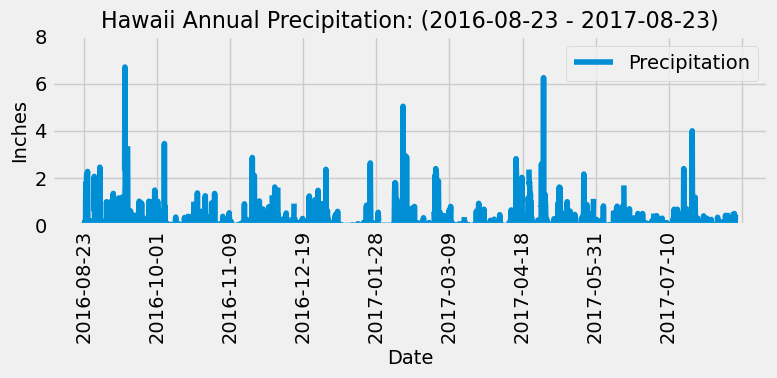

In [164]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Use Pandas Plotting with Matplotlib to plot the data
last_year_precip_df.plot(kind="line", x="Date", y="Precipitation", xticks=np.arange(0, 2300, step=(250)), 
    rot=90, figsize=(8,4), fontsize=14)
plt.title(f"Hawaii Annual Precipitation: ({date_range})", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Inches", fontsize=14)
plt.ylim(0,8)
plt.tight_layout()
plt.savefig("Images/hawaii_precipitation.png")
plt.show()

In [145]:
# Use Pandas to calculate the summary statistics for the precipitation data
#AGGREGATE METHOD
#REFERENCED PANDAS.PYDATA.ORG "AGGREGATING STATISTICS"
summ_stats = last_year_precip_df.agg({"Precipitation": ["mean", "median", "var", "std", "sem"]})
summ_stats

,Precipitation
mean,0.177279
median,0.020000
var,0.212696
std,0.461190
sem,0.010259


In [146]:
# Use Pandas to calculate the summary statistics for the precipitation data
#ANOTHER SUMMARY C/ .DESCRIBE()
last_year_precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [147]:
# Design a query to calculate the total number of stations in the dataset
#USING MEASUREMENT CLASS
station_count = session.query(Measurement.station).\
    group_by(Measurement.station).count()


#USING STATIONS CLASS
station_class_count = session.query(Station.station).count()

print(f"Station count by Measurement class is {station_count}.")
print(f"Station count by Station class is also {station_class_count}.")

Station count by Measurement class is 9.
Station count by Station class is also 9.


In [148]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#REFERENCED DOCS.SQLALCHEMY.ORG QUERY API func.count
counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [149]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = counts[0][0]
most_active_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
most_active_query

[(54.0, 85.0, 71.66378066378067)]

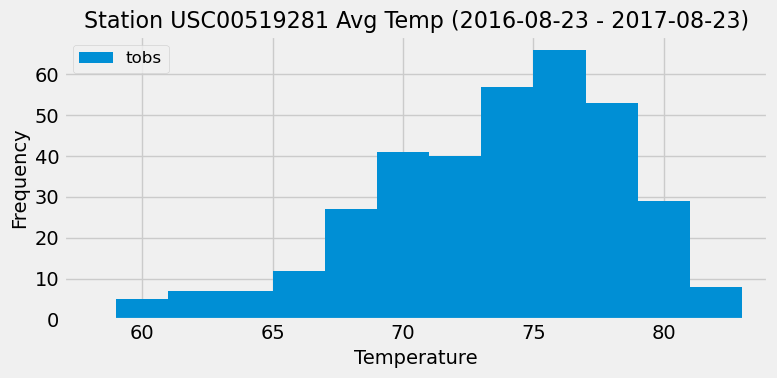

In [160]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
querying = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= clean_date).filter(Measurement.station == most_active).\
        order_by(Measurement.date).all()

queries = pd.DataFrame(querying)
queries.plot(kind="hist", bins=12, label="Temperature", figsize=(8,4))
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Station {most_active} Avg Temp ({date_range})", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.xlim((most_active_query[0][0]+3), (most_active_query[0][1]-1))
plt.tight_layout()
plt.savefig("Images/station_avg_temp.png")
plt.show()

# Close Session

In [151]:
# Close Session
session.close()